
#Deep Learning Workshop #2 - Time Series
This notebook was created by Eden Levy & Elior Nehemya.


---
In this notebook we will:

1.   Explore the time series dataset for energy consuming: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
2.   Create a naive baseline model for the data
3.   Use classic ML algorithm, namely GBM, for the task and evaluate its results
4.   Build LSTM RNN model
5.   Introduce improvements to (4)

** * Each section is highly detailed in our report for further understanding. **

We use findings from a paper by Luis M. Candanedo et al. (2015) [1]: https://www.sciencedirect.com/science/article/pii/S0378778816308970

References:

> [1] Candanedo, L.M., Feldheim, V. and Deramaix, D., 2017. Data driven prediction models of energy use of appliances in a low-energy house. Energy and buildings, 140, pp.81-97.




---



# 0. Imports and Data Loading

Imports and getting access for our data via google colab service.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.layers import Flatten, Dense, LSTM, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential


# Google Drive mounting for reading data
from google.colab import drive
drive.mount('/content/drive/')

# Static seed for reproduction
seed = 0

Mounted at /content/drive/


In [0]:
# Dataset is now stored in a Pandas Dataframe
data = pd.read_csv('./drive/My Drive/Colab Notebooks/project_2/energydata_complete.csv', infer_datetime_format=True, parse_dates=True, index_col='date')

In [0]:
# Split data into train and test sets for model validations
def data_split(data):
  targets = data.iloc[:, 0]
  features = data.iloc[:, 1:]
  x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
  
  return x_train, x_test, y_train, y_test

In [0]:
x_train, x_val, y_train, y_val = data_split(data)
print('Data split into {}% train and {}% test'.format(x_train.shape[0] * 100 / data.shape[0], x_val.shape[0] * 100 / data.shape[0]))

# 1. Data Analysis

In [0]:
# Some insights about our data

print('#### Total number of NaN values in our data: {}'.format(data.isna().sum().sum()))
print ("#### Our data has {} number of examples and {} features.".format(data.shape[0], data.shape[1]))
print ("#### A quick look at our data:\n\n")
data.describe()

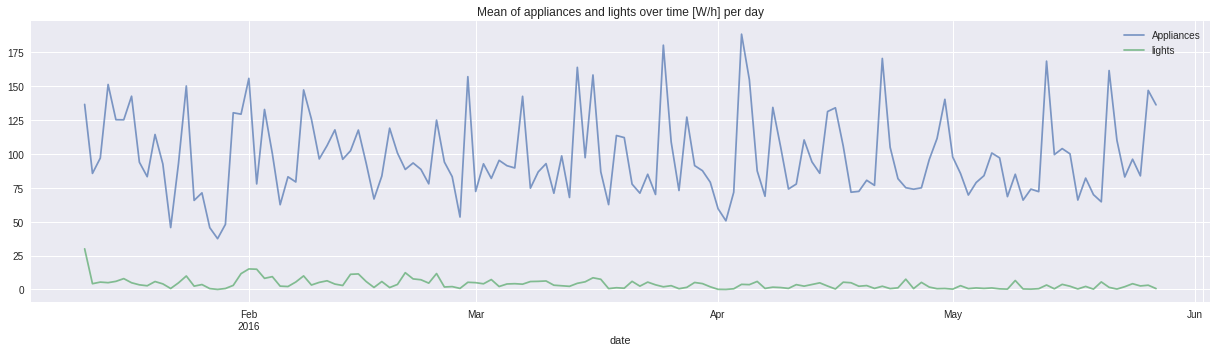

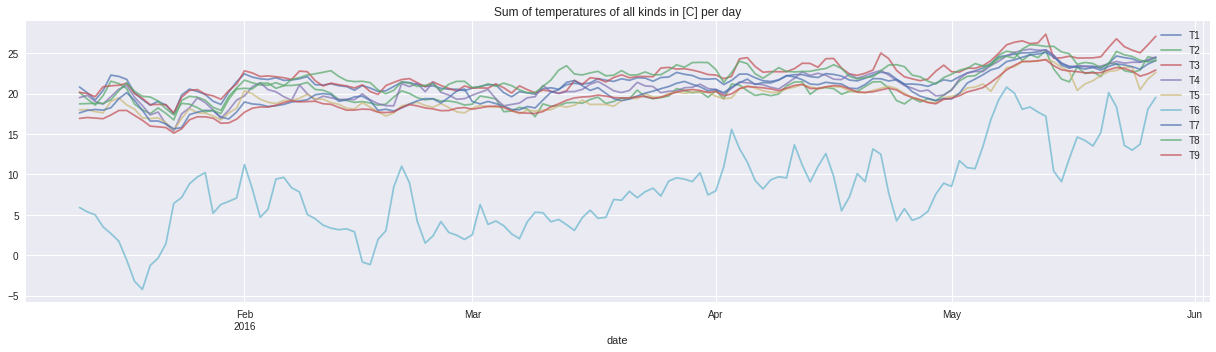

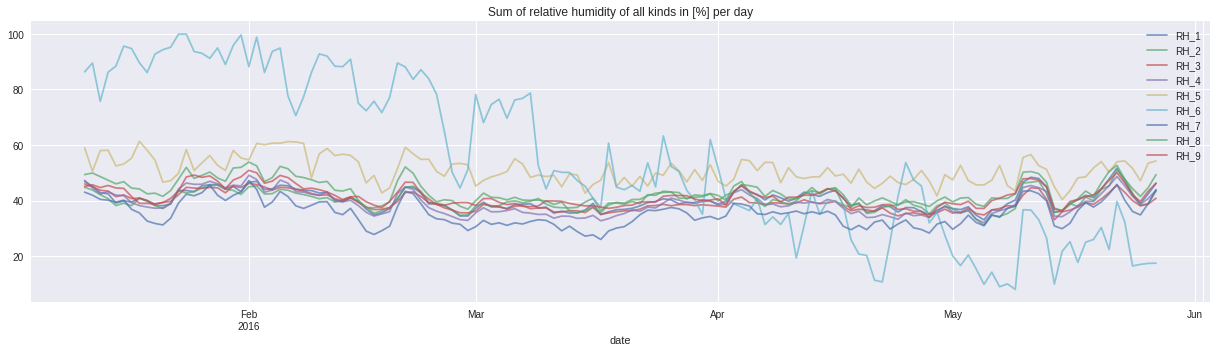

In [0]:
data['Appliances'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['lights'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
plt.title('Mean of appliances and lights over time [W/h] per day')
plt.legend()
plt.tight_layout()
plt.show()

data['T1'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T2'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T3'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T4'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T5'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T6'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T7'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T8'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['T9'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)

plt.title('Sum of temperatures of all kinds in [C] per day')
plt.legend()
plt.tight_layout()
plt.show()

data['RH_1'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_2'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_3'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_4'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_5'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_6'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_7'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_8'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)
data['RH_9'].resample('D').mean().plot(figsize=(17,5), alpha=0.7)

plt.title('Sum of relative humidity of all kinds in [%] per day')
plt.legend()
plt.tight_layout()
plt.show()

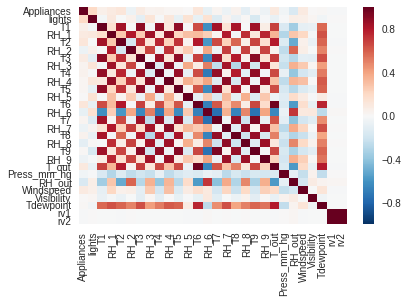

In [0]:
# Correlation map between each pair of features

corr = data.corr()
sns.heatmap(corr)

# 1.1. Data Preprocessing - Series to Supervised

In [0]:
look_back = 6
pred_steps = 1
n_features = 28

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  dff = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
  	cols.append(dff.shift(i))
  	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
  	cols.append(dff.shift(-i))
  	if i == 0:
  		names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  	else:
  		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  
  # drop rows with NaN values
  if dropnan:
  	agg.dropna(inplace=True)

  # Drops the columns we don't want to predict - the 140th column is our Y
  agg.drop(agg.columns[range( (n_features*n_in) + 1, (n_features*n_in) + 28)], axis=1, inplace=True)
  
  # Features, target
  x = agg.values[:,:(n_features*n_in)]
  y = agg.values[:,(n_features*n_in)]
  
  return x, y

# 2. Naive baseline model

In [0]:
# Make the target prediction be the average of Appliances throughout all the data
preds_train = np.zeros((y_train.shape[0], 1))
preds_train[:] = y_train.mean()

preds_val = np.zeros((y_val.shape[0], 1))
preds_val[:] = y_train.mean()

print('Mean of appliances in the training data is the static prediction: {}'.format(y_train.mean()))

Mean of appliances in the training data is the static prediction: 97.28401317456296


In [0]:
# Evaluating naive model with R/MSE scores
print('#### Naive baseline model evaluation:\n')

y_train_rs = y_train.values.reshape((y_train.shape[0], 1))
mse = mean_squared_error(y_train_rs, preds_train)
rmse = np.sqrt(mse)


print('#### Train Set: \nMSE: %.4f\nRMSE: %.4f' % (mse, rmse))

print('\n')

y_val_rs = y_val.values.reshape((y_val.shape[0], 1))
mse = mean_squared_error(y_val_rs, preds_val)
rmse = np.sqrt(mse)
# r2 = r2_score(y_val_rs, preds_val)

print('#### Test Set: \nMSE: %.4f\nRMSE: %.4f' % (mse, rmse))



# 3. Classic ML Algorithm - Gradient Boosting Machine

In [0]:
print('#### Gradient Boosting Regressor')

params = {
    'n_estimators': 500,
    'max_depth': 4,
    'min_samples_split': 2,
    'learning_rate': 0.01,
    'loss': 'ls'}

clf = GradientBoostingRegressor(**params)

x, y = series_to_supervised(data, 6, 1)
  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

clf.fit(x_train,y_train)
yhat_train = clf.predict(x_train)
train_mse = mean_squared_error(y_train, yhat_train)
train_rmse = np.sqrt(train_mse)


print('Train Set Evaluation:\nMSE: %.4f\nRMSE: %.4f' % (train_mse, train_rmse))

# clf.fit(x_test,y_test)
yhat = clf.predict(x_test)
test_mse = mean_squared_error(y_test, yhat)
test_rmse = np.sqrt(test_mse)

print('\n')
print('Test Set Evaluation:\nMSE: %.4f\nRMSE: %.4f' % (test_mse, test_rmse))

#### Gradient Boosting Regressor
Train Set Evaluation:
MSE: 6600.9609
RMSE: 81.2463


Test Set Evaluation:
MSE: 6197.1879
RMSE: 78.7222


In [0]:
def plot_feature_importance(df, clf):
  plt.figure(figsize=(12,6))
  table = pd.pivot_table(df,index=["date"],
               values = df.columns,
               aggfunc=[np.sum],fill_value=0)
  del table[("sum","Appliances")]

  #Plot Feature Importance
  feature_importance=clf.feature_importances_
  # make importances relative to max importance
  feature_importance=100.0*(feature_importance/feature_importance.max())
  sorted_idx=np.argsort(feature_importance)
  pos=np.arange(sorted_idx.shape[0])
  plt.subplot(1,1,1)
  plt.barh(pos,feature_importance[sorted_idx],align='center')
  plt.yticks(pos,table.columns.get_level_values(1))
  plt.xlabel('Relative Importance')
  plt.title('Variable Importance')
  plt.show()

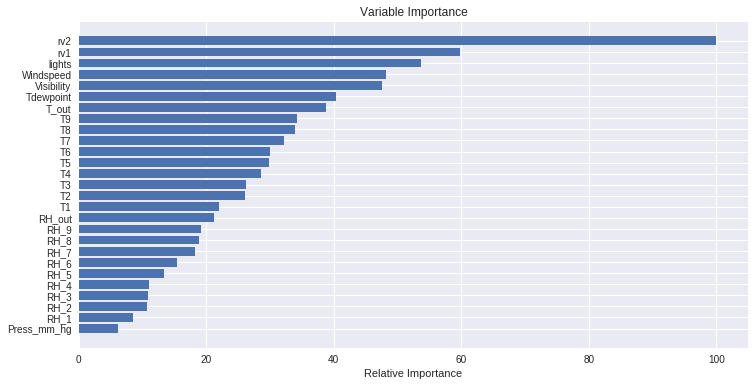

In [0]:
plot_feature_importance(data, clf)

# 4. Deep Neural Network Model - LSTM RNN

In [0]:
look_back = 5
pred_steps = 1
n_features = 28
n_batch = 10
n_epochs = 20
lstm_nodes = 32

In [0]:
def get_model():
  # network architecture
  model = Sequential()
  model.add(LSTM(lstm_nodes, return_sequences=True, input_shape=(look_back, n_features)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(LSTM(64))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(pred_steps))
  model.compile(loss='mse', optimizer='adam')
  
  return model

# plot history
def plot_graphs(history, title='Model Loss Function for Epochs'):
  plt.plot(np.sqrt(history.history['loss']), label='Train')
  plt.plot(np.sqrt(history.history['val_loss']), label='Test')
  plt.legend()
  plt.title(title)
  plt.ylabel('RMSE Loss')
  plt.xlabel('# Epoch')
  plt.show()

In [0]:
def rnn_0():
  data = pd.read_csv('./drive/My Drive/Colab Notebooks/project_2/energydata_complete.csv', infer_datetime_format=True, parse_dates=True, index_col='date')
  values = data.values
  
  x, y = series_to_supervised(data, look_back, 1)
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
  
  x_train = x_train.reshape(x_train.shape[0], look_back, n_features)
  x_test = x_test.reshape(x_test.shape[0], look_back, n_features)
  
  model = get_model()
  model.summary()
  # fit model
  history = model.fit(x_train, y_train, epochs=10, batch_size=n_batch, validation_data=(x_test, y_test), verbose=0, shuffle=True)
  
  preds_train = model.predict(x_train)
  preds_test = model.predict(x_test)
  
  rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
  
  print('#### RNN_0:\n\n')
  print('#### Train RMSE: %.4f' % rmse_train)
  print('#### Test RMSE: %.4f' % rmse_test)
  
  plot_graphs(history)
  
  return model, history, preds_train, preds_test

In [0]:
model, history, preds_train, preds_test = rnn_0()

# 4.1. LSTM with Data Scaling

In [0]:
#### IMPROVEMENT NUMBER 1 - NORMALIZATION

def rnn_1(scl=StandardScaler):
  data = pd.read_csv('./drive/My Drive/Colab Notebooks/project_2/energydata_complete.csv', infer_datetime_format=True, parse_dates=True, index_col='date')
  values = data.values

  x, y = series_to_supervised(data, look_back, pred_steps)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
  scaler = scl()
  scaler2 = scl()
  x_train_n = scaler.fit_transform(x_train)
  x_test_n = scaler2.fit_transform(x_test)

  x_train_n_rs = x_train_n.reshape(x_train_n.shape[0], look_back, n_features)
  x_test_n_rs = x_test_n.reshape(x_test_n.shape[0], look_back, n_features)

  model = get_model()

  history = model.fit(x_train_n_rs, y_train, epochs=n_epochs, batch_size=n_batch, validation_data=(x_test_n_rs, y_test), verbose=0, shuffle=True)
  
  preds_train = model.predict(x_train_n_rs)
  preds_test = model.predict(x_test_n_rs)
  
  rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
  
  print('#### RNN_1 (w/ ' + ('Standard' if scl is StandardScaler else 'MinMax') + ' scaling):\n\n')
  print('#### Train RMSE: %.4f' % rmse_train)
  print('#### Test RMSE: %.4f' % rmse_test)
  
  plot_graphs(history, 'RNN_1 with '+ ('Standard' if scl is StandardScaler else 'MinMax') +' Scaling')
  
  return model, history, preds_train, preds_test

#### RNN_1 (w/ MinMax scaling):


#### Train RMSE: 68.3382
#### Test RMSE: 69.1310


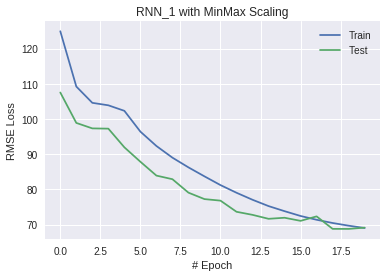

In [0]:
model, history, preds_train, preds_test = rnn_1(MinMaxScaler)

# 4.2. LSTM with Hyperparameter Tuning and New Architecture

In [0]:
#### IMPROVEMENT NUMBER 2

def rnn_2(scl=StandardScaler):
  data = pd.read_csv('./drive/My Drive/Colab Notebooks/project_2/energydata_complete.csv', infer_datetime_format=True, parse_dates=True, index_col='date')
  values = data.values

  x, y = series_to_supervised(data, look_back, 1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
  scaler = scl()
  scaler2 = scl()
  x_train_n = scaler.fit_transform(x_train)
  x_test_n = scaler2.fit_transform(x_test)

  x_train_n_rs = x_train_n.reshape(x_train_n.shape[0], look_back, n_features)
  x_test_n_rs = x_test_n.reshape(x_test_n.shape[0], look_back, n_features)

  model = get_model()

  history = model.fit(x_train_n_rs, y_train, epochs=n_epochs, batch_size=n_batch, validation_data=(x_test_n_rs, y_test), verbose=1, shuffle=True)
  
  preds_train = model.predict(x_train_n_rs)
  preds_test = model.predict(x_test_n_rs)
  
  rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
  
  print('#### RNN_2 (w/ ' + ('Standard' if scl is StandardScaler else 'MinMax') + ' scaling):\n\n')
  print('#### Train RMSE: %.4f' % rmse_train)
  print('#### Test RMSE: %.4f' % rmse_test)
  
  plot_graphs(history)
  
  return model, history, preds_train, preds_test

Train on 15778 samples, validate on 3945 samples
Epoch 1/20
15778/15778 [==============================] - 18s 1ms/step - loss: 16695.0472 - val_loss: 11761.4286
Epoch 2/20
15778/15778 [==============================] - 14s 900us/step - loss: 8629.5168 - val_loss: 5559.5735
Epoch 3/20
15778/15778 [==============================] - 14s 898us/step - loss: 5531.1447 - val_loss: 4414.3070
Epoch 4/20
15778/15778 [==============================] - 14s 903us/step - loss: 5052.8630 - val_loss: 4149.7515
Epoch 5/20
15778/15778 [==============================] - 14s 893us/step - loss: 4933.6359 - val_loss: 4112.2679
Epoch 6/20
15778/15778 [==============================] - 14s 890us/step - loss: 4838.0495 - val_loss: 4148.6683
Epoch 7/20
15778/15778 [==============================] - 14s 892us/step - loss: 4772.6720 - val_loss: 4089.6253
Epoch 8/20
15778/15778 [==============================] - 14s 900us/step - loss: 4800.3837 - val_loss: 3997.4261
Epoch 9/20
15778/15778 [=======================

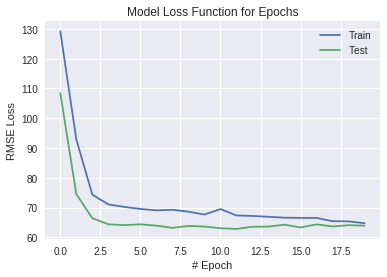

In [0]:
look_back = 12
pred_steps = 1
n_features = 28
n_batch = 32
n_epochs = 20
lstm_nodes = 512

model, history, preds_train, preds_test = rnn_2()